
# Project: Investigate a No-show appointments data set

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The dataset provides information for over 110000 medical appointments in Brazil. It contains details about the person booking the appointment and the appointment itself. The most crucial piece of information is whether the appointment was missed. The dataset is divided into 14 columns:
- PatientId -  patient identifier
- AppointmentID  - appointment identifier
- Gender - male or female
- ScheduledDay - time when the appointment was booked
- AppointmentDay - time when the appointment was to take place
- Age - age of the patient
- Neighbourhood - where the appointment is taking place
- Scholarship - this filed states whether the patient is a beneficient of the Brazilian social welfare program
- Hipertension - states whether the patient has hypertension
- Diabetes - states whether the patient is a  diabetic
- Alcoholism - states whether the patient is an  alcoholic
- Handcap - states if the patient is handicapped and what level
- SMS_received - states whether the patient received the text message with the appointment reminder
- No-show - states whether the patient missed the patient missed the visit

No-show appointment generates a huge cost to the public healthcare budget. Recent estimates for the UK give the figure
1 bln pounds, so it is 1.4 bln dollars. For Brazil with a much higher population, this cost is probably even greater. So being able to reduce no-show appointments could generate significant savings to the healthcare budget. This project is trying to analyze what are the common characteristics of the no-show appointments.
What are there any factors that make the missing appointment more probable?


In [173]:
# importing packages
import pandas as pd
import numpy as np
import seaborn as sbn
import calendar
import matplotlib.pyplot as plt
sbn.set()
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [174]:
# loading csv file into a dataframe
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv', encoding = 'cp860')

In [175]:
# examining first three rows
df.head(3)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No


In [176]:
# checking dimension of the dataframe
df.shape

(110527, 14)

We know that the dataframe consists of 110527 rows and 14 columns

In [177]:
# looking into summary of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


There are not null values in the dataframe also. Some of of the datatypes require fixing: PatientID,ScheduledID, AppointmentDay, No-show.

In [178]:
# checking for the number of duplicates
sum(df.duplicated())

0

There are not any duplicates rows in the dataframe

Checking for null values(just to be 100% sure)

In [179]:
# checking for the number of null values
df.isnull().values.sum()

0

There are not any null values in the dataframe

In [180]:
# checking for unique values
df.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

There are 110527 unique appointments, however there are 61744 patients. Hence there are number of patients
with multiply appointments during the period. 

In [181]:
# printing descriptive statistics
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


There is so problem with the dataset minimu age is -1

In [182]:
# checking rows for which age has a negative value
df.query('Age<0')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROM├âO,0,0,0,0,0,0,No


There is only one such row in the dataframe

## Data Cleaning 

In [183]:
# removing row for age =-1
df =df[df.Age !=-1]

Fixing the column names

In [184]:
# changing column names to lower case
df.columns = df.columns.str.lower()

In [185]:
# renaming some columns for consistency
df.rename(columns={'patientid':'patient_id', 'appointmentid':'appointment_id', 'scheduledday': 'scheduled_day','appointmentday':
                   'appointment_day', 'no-show': 'no_show', 'hipertension': 'hypertension', 'handcap': 'handicap'}, inplace=True)

In [186]:
# creating two additional columns by spliting and removing redundant characters from scheduled_day and appointment_day
for x in ['scheduled_day', 'appointment_day']:
    df[x] = df[x].apply(lambda x: x[:-1].replace('T', ' '))
    df[[x,str(x[:-3]+'time')]] = df[x].str.split(' ', expand=True)

In [187]:
# for consistency and simplyfing calculations replacing Yes, No in the no_show column with 0,1 values
df.no_show= df.no_show.replace(['No', 'Yes'], [0,1])

In [188]:
# changing patient_id datatype from float to integer
df.patient_id = df.patient_id.astype(int)

In [189]:
# changing scheduled_day datatype from string to datetime
df['scheduled_day']=pd.to_datetime(df['scheduled_day'])

In [190]:
# changing appointment_day datatype from string to datetime
df['appointment_day']=pd.to_datetime(df['appointment_day'])

In [191]:
# checking time period when appointment booking was taking place
print(df.scheduled_day.min())
print(df.scheduled_day.max())

2015-11-10 00:00:00
2016-06-08 00:00:00


In [192]:
# checking time period when appointment was taking place
print(df.appointment_day.min())
print(df.appointment_day.max())

2016-04-29 00:00:00
2016-06-08 00:00:00


In [193]:
# checking unique values for appointment_time
df.appointment_time.nunique()

1

In [194]:
# printing the unique element 
df.appointment_time.unique()

array(['00:00:00'], dtype=object)

As by extracting time from appointment_day no additional information was gained so this column will be dropped 

In [195]:
# checking unique values for scheduled_time
df.scheduled_time.nunique()

37109

In [196]:
# extracting hour from the scheduled_time column
df['scheduled_time'] = df['scheduled_time'].apply(lambda x: x[0:2])

In [197]:
# changing datatype of scheduled_time from string to integer
df['scheduled_time'] =df['scheduled_time'].astype(int)

In [198]:
# checking unique values for scheduled_time
df.scheduled_time.nunique()

16

In [199]:
# creating additional column which stores how many days is between scheduled day and the appoinment day
df['days_between'] = df['appointment_day']-df['scheduled_day']

In [200]:
# extracting integer from timedeleta object
df['days_between']= df['days_between'].apply(lambda x:x.days)

In [201]:
# extracting day of the week from the appointment_day column and story it in the new column
df['week_day'] = df['appointment_day'].apply(lambda x:x.weekday_name)

In [202]:
# dropping redundant columns
df.drop(['appointment_time', 'appointment_day', 'scheduled_day', 'appointment_id'], axis=1, inplace=True)

In [203]:
# checking  three  random rows
df.sample(3)

,patient_id,gender,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,scheduled_time,days_between,week_day
94659,876791829392785,F,12,ANDORINHAS,0,0,0,0,0,0,0,17,0,Wednesday
61361,44198841462,F,38,S├âO BENEDITO,1,0,0,0,0,1,0,7,9,Wednesday
51934,66843393619951,M,19,JESUS DE NAZARETH,0,0,0,0,0,1,0,8,7,Tuesday


In [204]:
# looking into descriptive statistic including new columns
df.describe()

,patient_id,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,scheduled_time,days_between
count,1.105260e+05,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000
mean,1.474934e+14,37.089219,0.098266,0.197248,0.071865,0.030400,0.022248,0.321029,0.201934,10.774542,10.183794
std,2.560943e+14,23.110026,0.297676,0.397923,0.258266,0.171686,0.161543,0.466874,0.401445,3.216192,15.255034
min,3.921700e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,-6.000000
25%,4.172536e+12,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000
50%,3.173184e+13,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,4.000000
75%,9.438963e+13,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,13.000000,15.000000
max,9.999816e+14,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,21.000000,179.000000


There is another problem some values for the days_between column are negative

In [205]:
# checking the rows for which scheduled day was allegedly after appointment day
df.query('days_between<0')

,patient_id,gender,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,scheduled_time,days_between,week_day
27033,7839272661752,M,38,RESIST├èNCIA,0,0,0,0,1,0,1,10,-1,Monday
55226,7896293967868,F,19,SANTO ANT├õNIO,0,0,0,0,1,0,1,14,-1,Tuesday
64175,24252258389979,F,22,CONSOLA├ç├âO,0,0,0,0,0,0,1,13,-1,Wednesday
71533,998231581612122,F,81,SANTO ANT├õNIO,0,0,0,0,0,0,1,13,-6,Thursday
72362,3787481966821,M,7,TABUAZEIRO,0,0,0,0,0,0,1,6,-1,Tuesday


In [206]:
# removing rows wehere days_between is less than zero
df= df[df.days_between >=0]

<a id='eda'></a>
## Exploratory Data Analysis



## 1. What is the average no-show rate, how many patients missed the appointments, what is the breakdown for man and woman?

In [207]:
# printing the mean value from the no_show column
average =df.no_show.mean()
print(average)

0.201898281775


So roughly one in five appoinmtemnt is missed

In [208]:
# calculating no-show rate for men and women
pd.crosstab(df.no_show, df.gender,normalize='columns')

gender,F,M
no_show,,
0,0.796885,0.800362
1,0.203115,0.199638


Overall, no-show rate for men is slightly lower

In [209]:
# calculating the number of appointments for men and women
pd.crosstab(df.no_show, df.gender,margins=True)

gender,F,M,All
no_show,,,
0,57245,30962,88207
1,14591,7723,22314
All,71836,38685,110521


Overall, women booked much more appointments 71836 vs. 38685 for men

In [210]:
# creating a dataframe whith two columns patient_id and number of appointment missed by that patient
df_1 = pd.DataFrame(df.groupby('patient_id', as_index=False)['no_show'].sum())

In [211]:
# selecting only rows with patients that missed at least one appointment
df_1 = df_1.query('no_show>0')

In [212]:
# looking into some descriptive statistics.
df_1.describe()

,patient_id,no_show
count,1.766100e+04,17661.000000
mean,1.460444e+14,1.263462
std,2.540992e+14,0.730857
min,5.628261e+06,1.000000
25%,4.175888e+12,1.000000
50%,3.196321e+13,1.000000
75%,9.439578e+13,1.000000
max,9.996585e+14,18.000000


Number of patient that happend to missed at least one appointment is 17620, at least 75% of the patients that missed an appointment missed just one appointment, one patient missed 18 appointments

In [213]:
# printing the proportion of patients that has missed at least one appointment to overal number of patient
proportion = len(df_1)/df.patient_id.nunique()
print(proportion)

0.28349224694211694


## 2. How no-show rate differs within a week?

The appointment can be booked for different day  of the week. Is there any meaningful insight when looking for the no-show rate for different weekday?

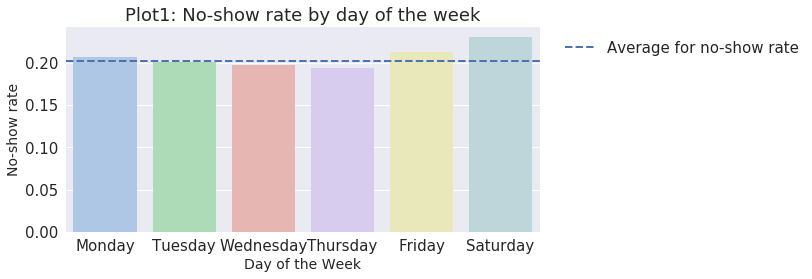

In [214]:
# plotting a barchart that shows no-show rate for each day of the week
sbn.set_style("darkgrid",)
sbn.set(font_scale=1.5)
sbn.factorplot(x="week_day", y="no_show", order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
                   data=df, saturation=0.5,palette="pastel",
                  kind="bar", ci=None, aspect=2);
plt.axhline(y=average,ls='--', linewidth=2)
plt.xlabel("Day of the Week", fontsize=14);
plt.ylabel("No-show rate", fontsize=14);
plt.legend(labels=['Average for no-show rate'],loc=9, bbox_to_anchor=(1.3, 1));
plt.title("Plot1: No-show rate by day of the week");

In [215]:
# creating a table which no-show rate for each day, starting with the lowest no-show rate.
pd.crosstab(df["no_show"],df["week_day"],normalize='columns').sort_values(1,ascending=True, axis=1)

week_day,Thursday,Wednesday,Tuesday,Monday,Friday,Saturday
no_show,,,,,,
0,0.806506,0.803139,0.799126,0.793554,0.787739,0.769231
1,0.193494,0.196861,0.200874,0.206446,0.212261,0.230769


The lowest no-show rate is for Thursday the highest for Saturday. Looking by the total number of appointments for each day will help to understand better the impact for the overall no-show rate.

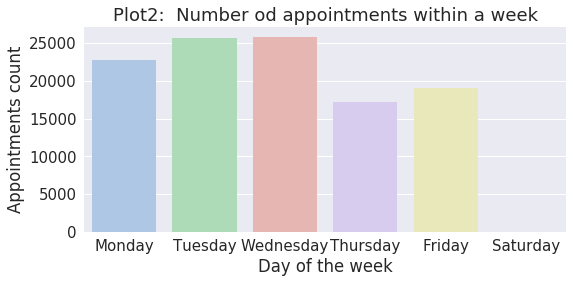

In [216]:
# plotting the countplot with  number of appointments for each day
g =sbn.factorplot(x="week_day",  order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
                   data=df, saturation=0.5,palette="pastel",
                  kind="count", ci=None, aspect=2);
g.set_axis_labels('Day of the week','Appointments count' );
plt.title("Plot2:  Number od appointments within a week");

In [217]:
# creating a table with a total number of appointments for each day
pd.crosstab(df["no_show"],df["week_day"], margins=True).sort_values(by ='All', ascending=False,axis=1)

week_day,All,Wednesday,Tuesday,Monday,Friday,Thursday,Saturday
no_show,,,,,,,
0,88207,20774,20488,18024,14982,13909,30
1,22314,5092,5150,4689,4037,3337,9
All,110521,25866,25638,22713,19019,17246,39


Even though, the no-show rate is visibly higher for Saturdays its imapact on overll no-show rate is insignificant since only 39 appointments where booked for that day. But there is a still a difference almost 2 % between  appointments booked for Thursday and the appointments booked for Friday. 

##  3. How the patient age is influencing the no-show rate?

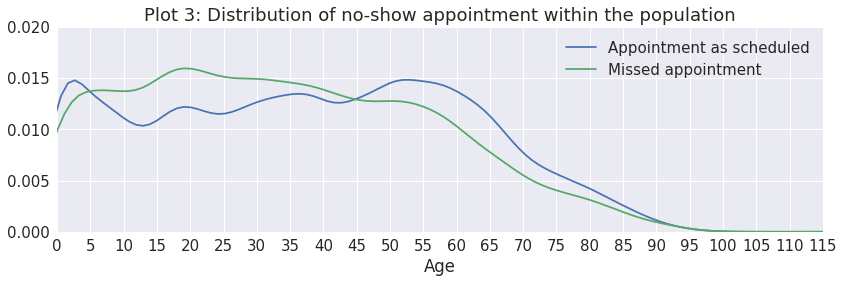

In [218]:
# plotting the distribution of no-show rate within the population.
sbn.set_style("darkgrid")
g = sbn.FacetGrid(df, hue = "no_show", size=4,aspect=3)
g.map(sbn.distplot, 'age', hist=False)
g.set(xlim=(0, df['age'].max()))
g.set(ylim=(0, 0.02))
g.set_axis_labels('Age', '')
plt.legend(labels=['Appointment as scheduled', 'Missed appointment']);
years = np.array(range(24))*5
plt.xticks(years)
plt.title('Plot 3: Distribution of no-show appointment within the population');

Above chart explains both the age distrubutions within the apointments and age groups with the highest no-show rate.
We can see that largest spece between green a blues plot is for the apointments made by gruop around 12 to 22 years old so there where we can look for the hihgest no-show rate.

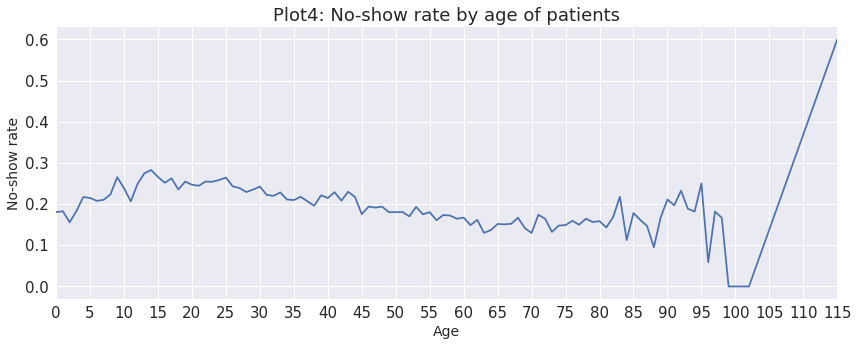

In [219]:
# plotting the no-show rate for different ages
df.groupby('age')['no_show'].mean().plot(figsize=(14,5))
years = np.array(range(24))*5
plt.xticks(years);
plt.xlabel("Age", fontsize=14);
plt.ylabel("No-show rate", fontsize=14);
plt.title('Plot4: No-show rate by age of patients');


The no-show rate chart looks a bit noisy. Looking at the distribution chart we can remove from the 
dataframe appointments made by patients 95 years old and above( the number of appointments made by this patients is miniscule). This should create a bit clearer picture

In [220]:
# keeping in the dataframe appointments made only by the patients less than 95 years old
df= df.query('age<95')

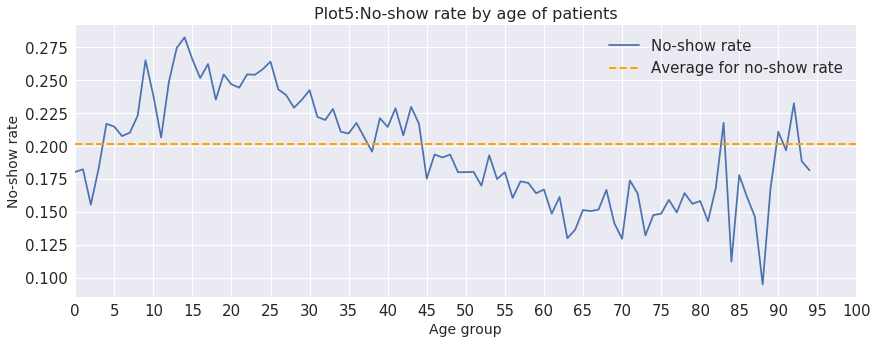

In [221]:
# plotting the no-show rate for different ages
sbn.set_style("darkgrid")
df.groupby('age')['no_show'].mean().plot(figsize=(14,5))
years = np.array(range(21))*5
plt.xlabel("Age group", fontsize=14);
plt.ylabel("No-show rate", fontsize=14);
plt.xticks(years);
plt.axhline(y=average,ls='--', linewidth=2, color='orange')
plt.legend(labels=['No-show rate','Average for no-show rate']);
plt.title('Plot5:No-show rate by age of patients', fontsize=16);

As we can see the no-show rate depends, greatly, on the patient age. It is below the average for the youngest patients. Then peaks around for patients
 14 years old. From which, the rate, is gradually, falling down. For the patients in their mid-forties is firmly below the overall average. Then levels out for those around 65 years old from which point is slightly increasing.

For the clearer analisys we can group the appointments depending on the age of the patients.

In [222]:
# creating distribution of ages so that each age group will contains 6.25% of the appointments
df.age.quantile(np.linspace(.0625, 1, 15, 0))


0.0625     2.0
0.1250     7.0
0.1875    12.0
0.2500    18.0
0.3125    22.0
0.3750    28.0
0.4375    32.0
0.5000    37.0
0.5625    42.0
0.6250    46.0
0.6875    51.0
0.7500    55.0
0.8125    60.0
0.8750    65.0
0.9375    73.0
Name: age, dtype: float64

In [223]:
# creating a new column in the dataframe. The column is to store the information to which age group belongs patient
# for whom the appointments was booked
df['age_bins'] = pd.cut(df['age'], [-1,2,7,12,18,22,28,32,37,42,47,51,55,60,65,73,116]
                        , labels=['0-2','3-7','8-12','13-18','19-22','23-28','29-32','33-37', '38-42', '43-47', '48-51',
                                 '52-55','56-60','61-65', '66-73', '73+'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


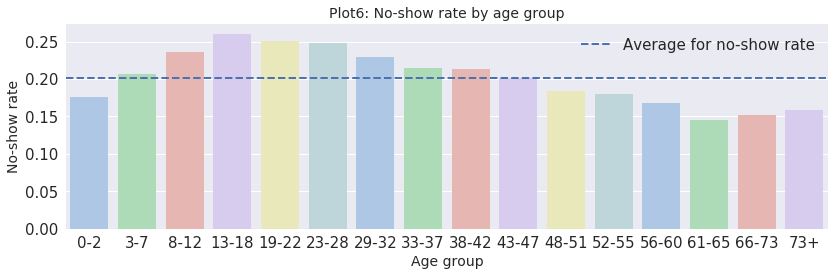

In [224]:
# plotting a chart with no-show rate for each of the age group
sbn.factorplot(x="age_bins", y="no_show", 
                   data=df, saturation=0.5,palette='pastel',
                  kind="bar", ci=None, aspect=3);
plt.xlabel("Age group", fontsize=14);
plt.ylabel("No-show rate", fontsize=14);
plt.axhline(y=average,ls='--', linewidth=2)
plt.legend(labels=['Average for no-show rate'])
plt.title("Plot6: No-show rate by age group",fontsize=14);


In [225]:
# creating a table with no-show rate for each age group
pd.crosstab(df.age_bins, df.no_show, normalize='index')[1]

age_bins
0-2      0.175774
3-7      0.206264
8-12     0.236747
13-18    0.260536
19-22    0.250172
23-28    0.247665
29-32    0.230061
33-37    0.214826
38-42    0.213391
43-47    0.201317
48-51    0.183438
52-55    0.179628
56-60    0.167528
61-65    0.145488
66-73    0.151708
73+      0.158652
Name: 1, dtype: float64

From the bar chart we can see  the group with the worst attendance is teenagers. The rate for that group is 0.26, so more than one in four appointments is missed. On the other hand, seniors in the group 61-65 years old are much more reliable, no-show rate for them is 0.145. Then for older cohorts silghtly rises.

## 4. How is time between booking and scheduled day influencing the no-show rate? 

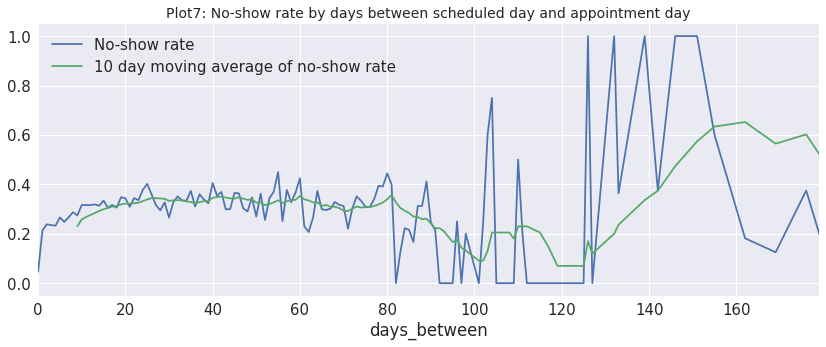

In [226]:
# plotting the no-show rate with a moving average
plt.figure(figsize= (14,5))
df.groupby('days_between')['no_show'].mean().plot()
moving = df.groupby('days_between')['no_show'].mean().rolling(window=10).mean().plot()
plt.legend(labels=['No-show rate','10 day moving average of no-show rate'])
plt.title("Plot7: No-show rate by days between scheduled day and appointment day",fontsize=14);
plt.show()

This chart even with moving average looks very noisy.

In [227]:
# checking the number for appointments that were made 100 and more days inadvance
len(df.query('days_between>=100'))

138

We can discard all the rows with appointmnets made 100 and more days in advance. There are only 138 of them and it may add some clarity to the chart.

In [228]:
# keeping in a data frame appointmenst that were made less than 100 days in advance
df = df.query('days_between<100')

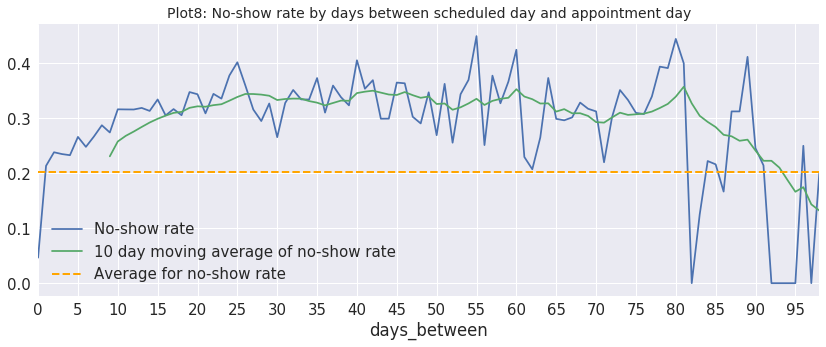

In [229]:
# plotting the no-show rate with a moving average
plt.figure(figsize= (14,5))
df.groupby('days_between')['no_show'].mean().plot()
moving = df.groupby('days_between')['no_show'].mean().rolling(window=10).mean().plot()
plt.axhline(y=average,ls='--', linewidth=2, color='orange')
plt.legend(labels=['No-show rate','10 day moving average of no-show rate','Average for no-show rate'])
days = np.array(range(20))*5
plt.xticks(days);

plt.title("Plot8: No-show rate by days between scheduled day and appointment day",fontsize=14);

plt.show()

It is still far from perfect. However, what we can see that the no-show rate for the is lower for the appointments with the shorther waiting time. Then the moving average levels out and from around 80 day waiting time no-show rate drops.

We can try to divide appointments in different groups depending on how many days patient was to wait for the visit.

In [230]:
# creating distribution of days between the scheduled day and the appointment day 
# so that each days group will contains 12.5% of the appointments
df.days_between.quantile(np.linspace(.125, 1, 7, 0))

0.125     0.0
0.250     0.0
0.375     1.0
0.500     4.0
0.625     7.0
0.750    15.0
0.875    27.0
Name: days_between, dtype: float64

It looks rather impossible, as the same day appointment are most frequent. So I will at least try to divide rest of appointments in equal groups

In [231]:
# creating an additional column in the dataframe storing the information to which  waiting time group belongs the appointment
df['days_bins'] = pd.cut(df['days_between'], [-1,0,2,5,9,17,28,100]
                        , labels=['same day','1-2 days','3-5 days','6-9 days','10-17 days','18-28 days','29 days+'])

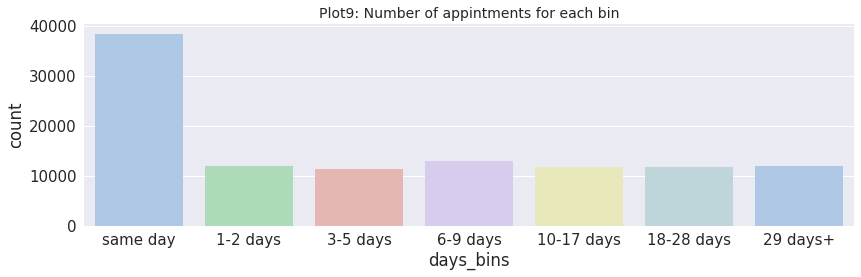

In [232]:
# plotting a bar chart with counts for each waiting time group
sbn.factorplot(x='days_bins', data=df, aspect=3,ci=None,kind= "count", palette="pastel",saturation=0.5);
plt.title("Plot9: Number of appintments for each bin",fontsize=14);

In [233]:
# grouping appoitments depending on days bin the belong to
df.groupby('days_bins')['days_bins'].count()

days_bins
same day      38529
1-2 days      11931
3-5 days      11297
6-9 days      12877
10-17 days    11840
18-28 days    11813
29 days+      12026
Name: days_bins, dtype: int64

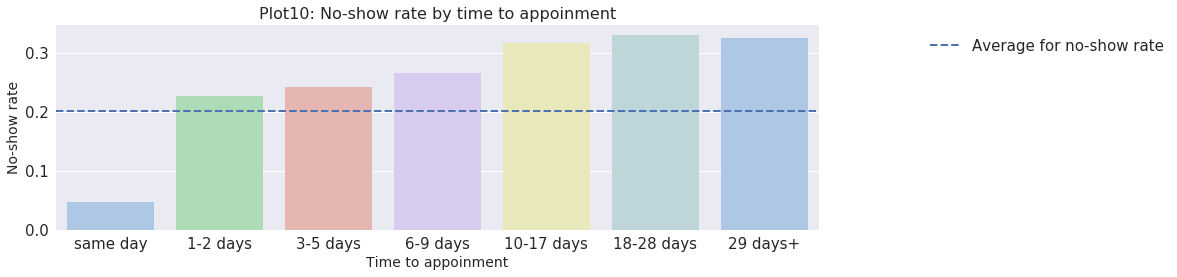

In [234]:
# plottong a bar chart with no show rate for different waiting time
sbn.factorplot(x="days_bins", y="no_show",
                   data=df, saturation=0.5,palette="pastel",
                  kind="bar", ci=None, aspect=3);
plt.xlabel("Time to appoinment", fontsize=14);
plt.ylabel("No-show rate", fontsize=14);
plt.axhline(y=average,ls='--', linewidth=2)
plt.legend(labels=['Average for no-show rate'],loc=9, bbox_to_anchor=(1.3, 1));
plt.title("Plot10: No-show rate by time to appoinment",fontsize=16);

In [235]:
# creating a table with a attendance rate for different waiting time groups
pd.crosstab(df["no_show"], df["days_bins"],normalize='columns')

days_bins,same day,1-2 days,3-5 days,6-9 days,10-17 days,18-28 days,29 days+
no_show,,,,,,,
0,0.953541,0.772609,0.757015,0.734488,0.682855,0.66867,0.673707
1,0.046459,0.227391,0.242985,0.265512,0.317145,0.33133,0.326293


The same day appointments have the lowest no-show rate - 0.046.  Sbusequently, the no-show rate rises for groups representing waiting time between 1 and 28 days. For appointmenst with a waiting time 29 days and more this rate slightly declines. So presuambly the same day appointments are the emergency ones. On the other side waiting time 29 days and more may improve the rate because the appointents are likely with specialists and patients do not want to lose  them.

## 5. SMS and non-shows in other words, be careful with your statistics! What is the real impact of text reminders?

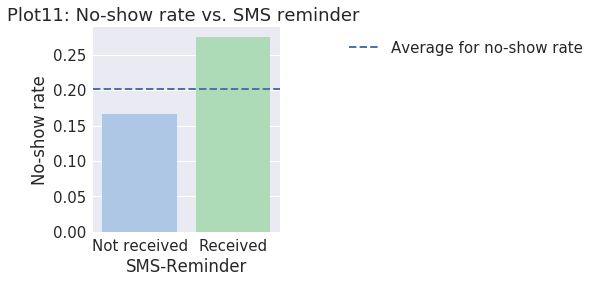

In [236]:
# plotting barchart for no-show vs. SMS reminders
g= sbn.factorplot(x="sms_received", y="no_show", 
                   data=df, saturation=0.5,palette="pastel",margin_titles=True, kind='bar',ci=None)

(g.set_axis_labels("SMS-Reminder","No-show rate")
.set_xticklabels(['Not received', 'Received']));
plt.axhline(y=average,ls='--', linewidth=2)
plt.legend(labels=['Average for no-show rate'],loc=9, bbox_to_anchor=(2, 1));
plt.title("Plot11: No-show rate vs. SMS reminder ");

In [237]:
# creating a table that show attendance rate for SMS reminders received and not received
pd.crosstab(df.no_show, df.sms_received, normalize='columns')

sms_received,0,1
no_show,,
0,0.833071,0.724387
1,0.166929,0.275613


Looking at the above statistic one may be under the impression that SMSs have a negative influence on the patient attendance. However, after the closer investigation this assumption may not hold true.


In [238]:
# filtering the dataframe so that only rows with sent SMS will
df_SMS = df.query('sms_received==1')

In [239]:
# looking into descriptive statistics for appointments for whith SMS
df_SMS.describe()

,patient_id,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,scheduled_time,days_between
count,3.538300e+04,35383.000000,35383.000000,35383.000000,35383.000000,35383.000000,35383.000000,35383.0,35383.000000,35383.000000,35383.000000
mean,1.439212e+14,37.457310,0.098805,0.192437,0.066020,0.023882,0.016307,1.0,0.275613,11.054687,18.713874
std,2.519335e+14,22.285687,0.298404,0.394220,0.248321,0.152682,0.138997,0.0,0.446829,3.268578,15.834014
min,5.376150e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,6.000000,3.000000
25%,3.926555e+12,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,8.000000,7.000000
50%,2.977446e+13,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,10.000000,14.000000
75%,9.361253e+13,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,14.000000,27.000000
max,9.999320e+14,94.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.0,1.000000,21.000000,98.000000


The minimum values for days is 3, so SMS are only sent to appointments that are booked at least three days in advance

In [240]:
# creating a dataframe with appointmenst that were booked at least three days in advance
df_3 = df.query('days_between>2')

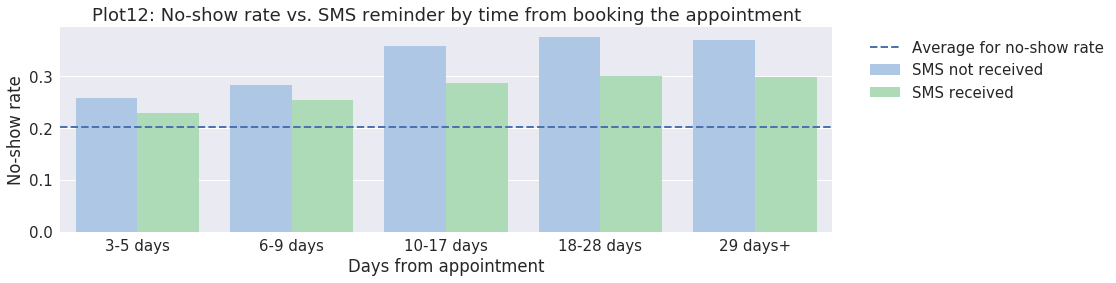

In [241]:
# plotting a barchart with no-show rate both for appointments with and without SMS remiders
g =sbn.factorplot(x="days_bins", y="no_show", hue="sms_received", order=['3-5 days','6-9 days',  '10-17 days', '18-28 days', '29 days+'],
data=df_3, saturation=0.5,palette="pastel", legend=False,kind="bar", ci=None, aspect=3);
g.set_axis_labels("Days from appointment", "No-show rate");
plt.axhline(y=average,ls='--', linewidth=2)
plt.title("Plot12: No-show rate vs. SMS reminder by time from booking the appointment",fontsize=18);
plt.legend(labels=['Average for no-show rate','SMS not received', 'SMS received'],loc=9, bbox_to_anchor=(1.2, 1));


In [242]:
# calculating attendace rate for different waiting times bins depending on wheter patient recived SMS
pd.crosstab(index=df_3['no_show'], columns=[df_3['days_bins'],df_3['sms_received']],normalize='columns')

days_bins    3-5 days            6-9 days           10-17 days            \
sms_received        0         1         0         1          0         1   
no_show                                                                    
0             0.74243  0.769832  0.717139  0.745169   0.641453  0.712952   
1             0.25757  0.230168  0.282861  0.254831   0.358547  0.287048   

days_bins    18-28 days           29 days+            
sms_received          0        1         0         1  
no_show                                               
0              0.623167  0.69879  0.630501  0.700377  
1              0.376833  0.30121  0.369499  0.299623

Now the impact looks much more clear and it looks like that text messages with reminders improve the attendace. for example waiting time between 10-17 days no-show rate equals to 0.358 if the SMS was not received, however, fort he same group, with received sms, the no-show rate drops to 0.287.
Initial statistics was misleading because SMS are sent for those appointments wich are more likely to be missed, i.e. the ones book in advance.

## 6. What is the influence of excessive alcohol consumtption on no-show rate?

In [243]:
# printing descriptive statistics for appointments where patient was diagnosed with alcoholism
df.query('alcoholism==1').describe()

,patient_id,age,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,scheduled_time,days_between
count,3.357000e+03,3357.000000,3357.000000,3357.000000,3357.000000,3357.0,3357.000000,3357.000000,3357.000000,3357.000000,3357.000000
mean,1.634369e+14,49.589812,0.157283,0.394996,0.098898,1.0,0.026214,0.251713,0.201072,10.726244,6.762586
std,2.793914e+14,12.705617,0.364122,0.488923,0.298569,0.0,0.184059,0.434062,0.400862,3.205116,11.090319
min,4.837888e+08,4.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,6.000000,0.000000
25%,4.639447e+12,41.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,8.000000,0.000000
50%,3.398355e+13,50.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,10.000000,1.000000
75%,9.377142e+13,59.000000,0.000000,1.000000,0.000000,1.0,0.000000,1.000000,0.000000,13.000000,8.000000
max,9.986957e+14,85.000000,1.000000,1.000000,1.000000,1.0,3.000000,1.000000,1.000000,20.000000,90.000000


Looking at the descriptive statistics of the dataframe we know that the youngest person diognosed with alcoholism is four years old. Outrageous as it may sound, this is actually may be the fact, I will assume it is not mistake.

In [244]:
# creating a dataframe with appoinmtents for patients at least four years old
df_3 = df.query('age>3')

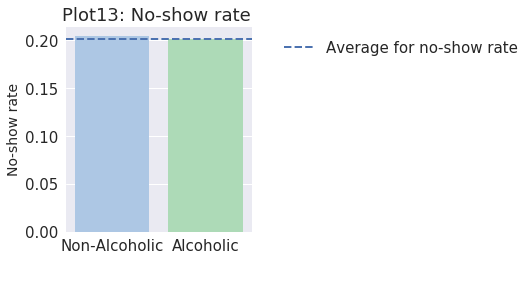

In [245]:
# plotting a bar chart for alcoholism vs. no-show
g= sbn.factorplot(x="alcoholism", y="no_show",  
                   data=df_3, saturation=0.5,palette="pastel",
                  kind="bar", ci=None, aspect=1);
plt.xlabel(" ");
plt.ylabel("No-show rate", fontsize=14);
plt.title("Plot13: No-show rate ",fontsize=18);
plt.axhline(y=average,ls='--', linewidth=2)
g.set_xticklabels(['Non-Alcoholic', 'Alcoholic']);
plt.legend(labels=['Average for no-show rate'],loc=9, bbox_to_anchor=(1.8, 1));

In [246]:
# calculating the rate for no-show appointmnets 
pd.crosstab(df_3["alcoholism"],df_3["no_show"],normalize='index')

no_show,0,1
alcoholism,,
0,0.795931,0.204069
1,0.798928,0.201072


At first glance, it seems that alcoholism has a minimal positive impact on patient attendance. Which is a bit counterintuitive. Let's look a bit closer at this metrics.

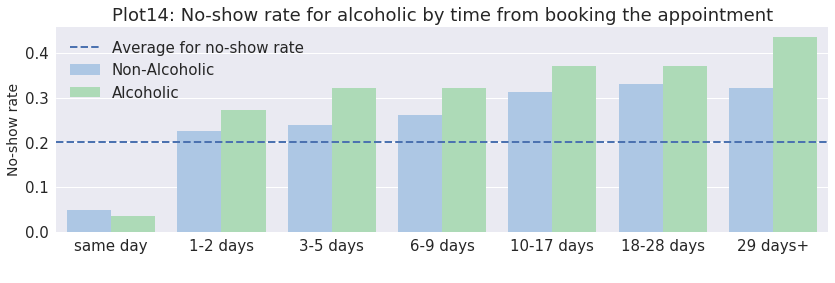

In [247]:
# bar chart for now-show vs. alcoholism for different times from booking appointment
g =sbn.factorplot(x="days_bins", y="no_show", hue="alcoholism",
                   data=df_3, saturation=0.5,palette='pastel',aspect=3, legend=False,kind='bar', ci=None)
plt.xlabel(" ");
plt.ylabel("No-show rate", fontsize=14);
plt.title("Plot14: No-show rate for alcoholic by time from booking the appointment",fontsize=18);
plt.axhline(y=average,ls='--', linewidth=2)
plt.legend(labels=['Average for no-show rate','Non-Alcoholic', 'Alcoholic'],);

In [248]:
# creating a tabel showing a no-show rate for alcoholic and non-alcoholic dependening on time between booking
# and the actual appointment
pd.crosstab(index=df_3["no_show"], columns=[df_3["days_bins"],df_3["alcoholism"]],normalize='columns')

days_bins   same day            1-2 days            3-5 days            \
alcoholism         0         1         0         1         0         1   
no_show                                                                  
0           0.950776  0.963589  0.773525  0.727829  0.760895  0.678063   
1           0.049224  0.036411  0.226475  0.272171  0.239105  0.321937   

days_bins   6-9 days           10-17 days          18-28 days           \
alcoholism         0         1          0        1          0        1   
no_show                                                                  
0           0.737803  0.679045   0.686381  0.62963    0.66997  0.62963   
1           0.262197  0.320955   0.313619  0.37037    0.33003  0.37037   

days_bins   29 days+            
alcoholism         0         1  
no_show                         
0           0.678054  0.563452  
1           0.321946  0.436548

Impact of alcoholism has more complex then it seems. For the same day appointment, attendence is very high, with only 0.036 no-show rate, comapring to 0.049 for non-alcoholic patients. However, for longer waiting time the attendence is much worse. For exapmle, for those waitng 29 days and more, no-show rate for is 0.43 for patient diagnosed with alcoholism and 0.32 for the rest.

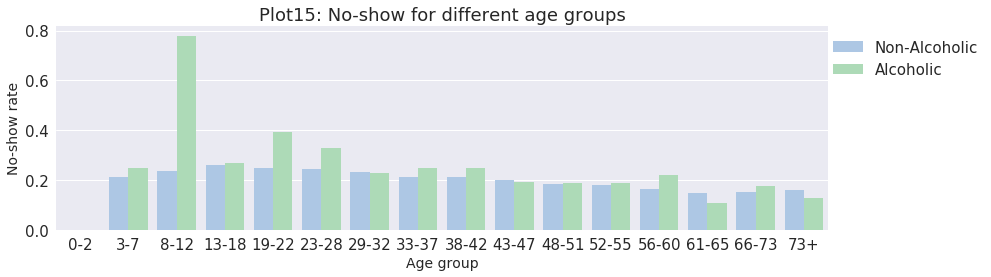

In [249]:
# plotting a barch chart for no-show vs. alcoholism for different age groups.
sbn.factorplot(x='age_bins', y="no_show", hue="alcoholism",
                   data=df_3, saturation=0.5, palette="pastel",legend=False,
                  kind="bar", ci=None, aspect=3);
plt.xlabel("Age group", fontsize=14);
plt.ylabel("No-show rate", fontsize=14);
plt.title("Plot15: No-show for different age groups",fontsize=18);

plt.legend(labels=['Non-Alcoholic', 'Alcoholic'],loc=9, bbox_to_anchor=(1.1, 1));

In [250]:
# calculating attendance rate for diferent age groups depending on dignosed alcoholism
pd.crosstab(columns=df_3["no_show"], index=[df_3["age_bins"],df_3["alcoholism"]],normalize='index')

no_show                     0         1
age_bins alcoholism                    
0-2      0           0.000000  0.000000
         1           0.000000  0.000000
3-7      0           0.787884  0.212116
         1           0.750000  0.250000
8-12     0           0.764344  0.235656
         1           0.222222  0.777778
13-18    0           0.739475  0.260525
         1           0.733333  0.266667
19-22    0           0.750606  0.249394
         1           0.607143  0.392857
23-28    0           0.753963  0.246037
         1           0.671329  0.328671
29-32    0           0.769809  0.230191
         1           0.773333  0.226667
33-37    0           0.786252  0.213748
         1           0.753191  0.246809
38-42    0           0.788271  0.211729
         1           0.750000  0.250000
43-47    0           0.798397  0.201603
         1           0.808511  0.191489
48-51    0           0.816841  0.183159
         1           0.810127  0.189873
52-55    0           0.821732  0.178268
         1           0.810573  0.189427
56-60    0           0.835075  0.164925
         1           0.780822  0.219178
61-65    0           0.852165  0.147835
         1           0.892019  0.107981
66-73    0           0.849471  0.150529
         1           0.823529  0.176471
73+      0           0.841200  0.158800
         1           0.873563  0.126437

Eleven out of fifteen age groups have a no-show rate higher for alcoholics than non-alcoholics. Some of the no-show rate for alcoholics is significantly higher(for example group 8-12 years old). So this may be slightly puzzling why alcoholism improves the overall rate (slightly but still).

Let's try to investigate the distribution of alcoholism within the age groups.

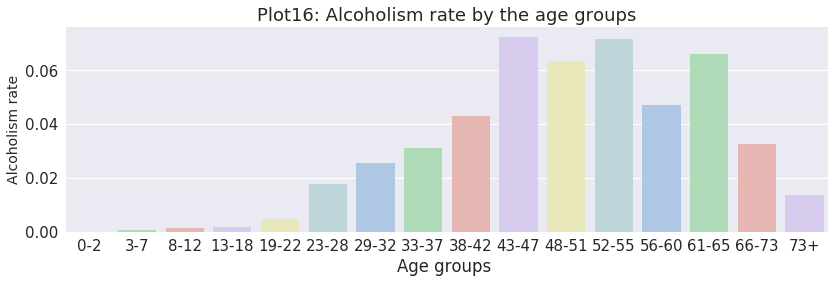

In [251]:
# bar chart with alcoholism rate for different age groups
sbn.factorplot(x='age_bins', y='alcoholism',
                   data=df_3, saturation=0.5, palette="pastel",legend=False,
                  kind="bar", ci=None, aspect=3);
plt.xlabel("Age groups ");
plt.ylabel("Alcoholism rate", fontsize=14);
plt.title("Plot16: Alcoholism rate by the age groups",fontsize=18);


So the alcoholism rate is high for the groups -43-65 years old, the same groups  have attendance rate below average. That shows that it is worth to look for alcoholism not separately but in combination with age.

## 7. Scholarship. Is there any realtionship between no-shows and participation in the welafare program?

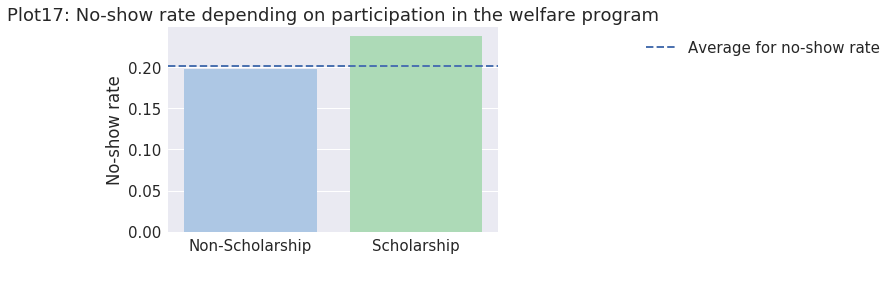

In [252]:
# plotting a bar chart for no-show rate vs. scholarship
g =sbn.factorplot(x='scholarship', y="no_show",  data=df, saturation=0.5,palette="pastel",kind="bar", ci=None, aspect=1.5)
g.set_xticklabels(['Non-Scholarship', 'Scholarship']);
g.set_axis_labels(' ', 'No-show rate');
plt.title("Plot17: No-show rate depending on participation in the welfare program",fontsize=18);
plt.axhline(y=average,ls='--', linewidth=2)
plt.legend(labels=['Average for no-show rate'],loc=9, bbox_to_anchor=(1.8, 1));

In [253]:
# calculating the rate for no-show appointmnets 
pd.crosstab(df["scholarship"],df["no_show"],normalize='index')

no_show,0,1
scholarship,,
0,0.802085,0.197915
1,0.762695,0.237305


In general, participation in the social benefit programme has a negative impact on attendance.No-show rate for appointment made by patients participating in the program is 0.237 vs. 0.197 for non-participant.

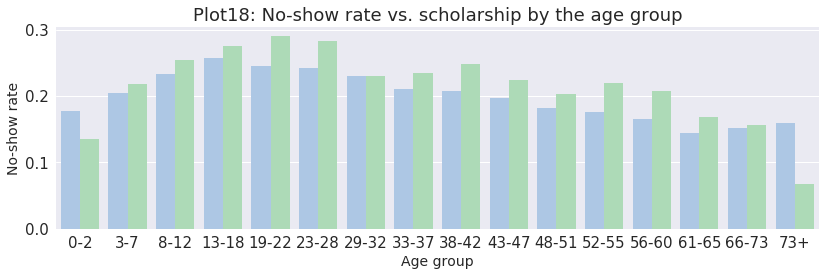

In [254]:
# plotting no-show appointment vs. scholarship for different age groups
sbn.factorplot(x='age_bins', y="no_show", hue='scholarship',legend=False,
                   data=df, saturation=0.5, palette="pastel",
                  kind="bar", ci=None, aspect=3)
plt.xlabel("Age group", fontsize=14);
plt.ylabel("No-show rate", fontsize=14);
plt.title("Plot18: No-show rate vs. scholarship by the age group",fontsize=18);

For all but two age groups the attendance is worse for those taking part in the programme. The youngest cohort(0-2), can be easily explained looking at the Wikipedia site https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia
.For children to be registered in the programme they need to be vaccinated. 

What about the oldest cohort?

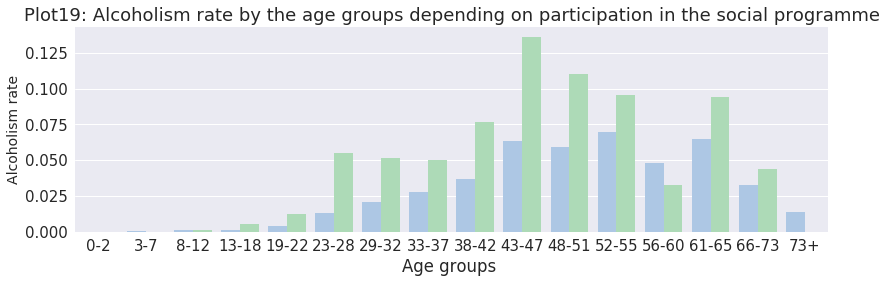

In [255]:
# plotting alcoholism rate vs. scholarship for different age groups
sbn.factorplot(x='age_bins', y='alcoholism', hue='scholarship',
                   data=df, saturation=0.5, palette="pastel",legend=False,
                  kind="bar", ci=None, aspect=3);
plt.xlabel("Age groups ");
plt.ylabel("Alcoholism rate", fontsize=14);
plt.title("Plot19: Alcoholism rate by the age groups depending on participation in the social programme",fontsize=18);



In [256]:
# clculating alcoholism rate or diferent age groups for both scholarship and anon-scholarsip patients
pd.crosstab(columns=df_3["alcoholism"], index=[df_3["age_bins"],df_3["scholarship"]],normalize='index')

alcoholism                   0         1
age_bins scholarship                    
0-2      0            0.000000  0.000000
         1            0.000000  0.000000
3-7      0            0.999184  0.000816
         1            1.000000  0.000000
8-12     0            0.998542  0.001458
         1            0.998847  0.001153
13-18    0            0.998653  0.001347
         1            0.994778  0.005222
19-22    0            0.996138  0.003862
         1            0.987261  0.012739
23-28    0            0.987151  0.012849
         1            0.945032  0.054968
29-32    0            0.979100  0.020900
         1            0.948373  0.051627
33-37    0            0.972509  0.027491
         1            0.950201  0.049799
38-42    0            0.963441  0.036559
         1            0.923348  0.076652
43-47    0            0.936460  0.063540
         1            0.863791  0.136209
48-51    0            0.940867  0.059133
         1            0.889943  0.110057
52-55    0            0.930049  0.069951
         1            0.904282  0.095718
56-60    0            0.951918  0.048082
         1            0.967593  0.032407
61-65    0            0.935301  0.064699
         1            0.905594  0.094406
66-73    0            0.967549  0.032451
         1            0.956098  0.043902
73+      0            0.986359  0.013641
         1            1.000000  0.000000

It looks like for the oldest group the alcoholism is at the zero level. So the oldest group in social security programme seems to be more health conscious. Or is it just a survivorship bias? Because for most other groups the acoholism is much higher if person takes part in the social walfare programme. 


<a id='conclusions'></a>
## Conclusions

This project is by no means an exhaustive analysis into reasons behind the no-show appointments. However, it has found that a number of factors influence the no-show rate: age, appointment waiting time, SMS reminder, alcoholism, and scholarship are significant in estimating the probability of missing appointment.

1. The time between scheduling appointment and the actual appointment is a very significant factor. The lowest no-show rate has the same day appointment
2. The age is an important factor in estimating the probability of missing appointment. Very young children (0-2) years old appointments and those in group age above 43 have the no-show rate below average.
3. SMS messages are sent only to appointments booked at least three days in advance. For those appointments, text messages improve the no-show rate.
4. Alcoholism seems to be not an important factor, however when looking in combination with time between booking appointment and actual appointment it shows that no-show rate for patients with alcoholism is higher for advance booking
5. Scholarship increases the no-show rate.
6. The highest no-show rate within a week is for Saturday
7. Gender seems to not to have much  influence the overall no-show rate


Limitations

1. The correlation between independent variables. For example, alcoholism and age distribution is similar to the distribution of no-show rate and age. 
2. The dataset contains very little appointments for Saturday.
3. After trying to extract appointment time from appointment day I have found out that the value is just 00:00:00 for all fields. It would be interesting to know what is the actual time of the appointment and how it influences the no-show rate.
4. The appointments days are for the period just above month:
2016-04-29 00:00:00
2016-06-08 00:00:00;
 It would be nice to know how the no-show rate is distributed within a year.


In [257]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0